## Библиотеки

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms
import torchvision.models as models

In [199]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка датасета

In [200]:
kaggle_path = '/content/drive/MyDrive/MFTI/SEM_02/Deep_learning/kaggle.json'
!mkdir -p ~/.kaggle
!cp "{kaggle_path}" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [202]:
!kaggle competitions download -c mipt-dl-captcha-2025

mipt-dl-captcha-2025.zip: Skipping, found more recently modified local copy (use --force to force download)


### Распаковка датасета

In [235]:
with zipfile.ZipFile('/content/mipt-dl-captcha-2025.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mipt_dl_captcha')

for root, dirs, files in os.walk('/content/mipt_dl_captcha'):
    for name in files:
        print(os.path.join(root, name))

/content/mipt_dl_captcha/mds-misis-dl-captchan/sample_submission.csv
/content/mipt_dl_captcha/mds-misis-dl-captchan/labels.npy
/content/mipt_dl_captcha/mds-misis-dl-captchan/images.npy
/content/mipt_dl_captcha/mds-misis-dl-captchan/images_sub.npy


In [236]:
images = np.load('/content/mipt_dl_captcha/mds-misis-dl-captchan/images.npy')
labels = np.load('/content/mipt_dl_captcha/mds-misis-dl-captchan/labels.npy')
img_submission = np.load('/content/mipt_dl_captcha/mds-misis-dl-captchan/images_sub.npy')

submission = pd.read_csv('/content/mipt_dl_captcha/mds-misis-dl-captchan/sample_submission.csv')

In [205]:
type(images[1])

numpy.ndarray

In [206]:
output = len(np.unique(labels))
print(f'Число классов: {output}')

Число классов: 26


### Визуализируем изображения

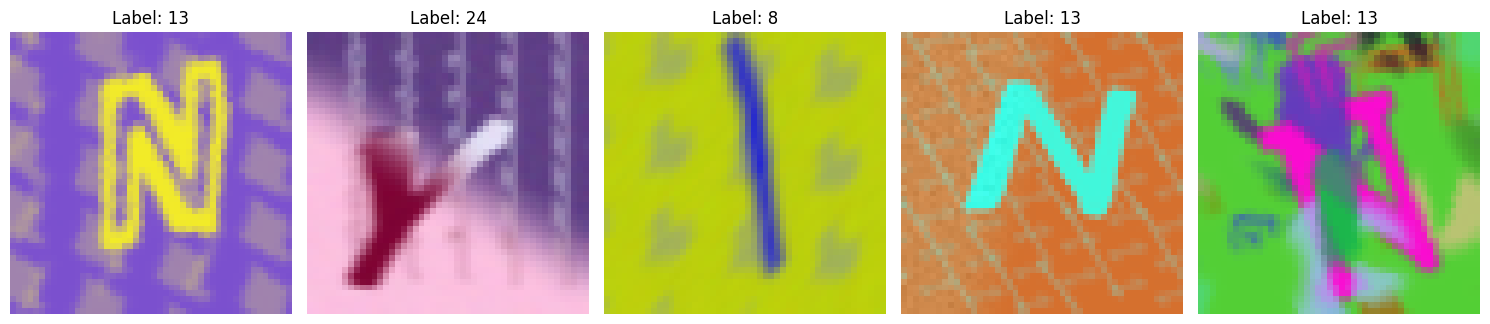

In [207]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].imshow(images[i])
    ax[i].set_title(f"Label: {labels[i]}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Делим выборку на Train, Val

In [208]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(16000, 48, 48, 3)
(2000, 48, 48, 3)
(16000,)
(2000,)
(2000, 48, 48, 3)
(2000,)


## Нормализация изображений

In [209]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [210]:
def transform_images(images, transform):
    transformed = [transform(Image.fromarray(img)) for img in images]
    X_tensor = torch.stack(transformed)
    return X_tensor

def create_dataloader(images, labels, transform, batch_size=64, shuffle=True):
    X_tensor = transform_images(images, transform)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [211]:
train_loader = create_dataloader(X_train, y_train, transform_train)
test_loader = create_dataloader(X_test, y_test, transform)
val_loader = create_dataloader(X_val, y_val, transform)

In [212]:
print(train_loader.dataset[0][0].shape)
print(train_loader.dataset[0][0])
print(train_loader.dataset[0][1])

torch.Size([3, 48, 48])
tensor([[[-1.0000, -0.1216, -0.1137,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -0.1216, -0.1137,  ...,  0.4118,  0.4980,  0.5765],
         [-1.0000, -0.1216, -0.1137,  ...,  0.4118,  0.5059,  0.5765],
         ...,
         [-0.2471, -0.1843, -0.0588,  ..., -0.2471, -0.3725, -1.0000],
         [-0.2471, -0.1843, -0.1843,  ..., -0.2471, -0.3725, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.2471, -0.3098, -1.0000]],

        [[-1.0000,  0.7490,  0.6706,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000,  0.7490,  0.6784,  ..., -0.1294, -0.2471, -0.3725],
         [-1.0000,  0.7490,  0.6784,  ..., -0.1294, -0.2627, -0.3725],
         ...,
         [ 0.7569,  0.6941,  0.6314,  ...,  0.8196,  0.8824, -1.0000],
         [ 0.7569,  0.7569,  0.6941,  ...,  0.8196,  0.8196, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.7569,  0.8196, -1.0000]],

        [[-1.0000, -0.0039,  0.0588,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -0

# Модели


### Кастомная ModelCNN

In [213]:
class ModelCNN(nn.Module):
    def __init__(self, num_classes):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 24x24
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64 , 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 12x12
        self.bn2 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = x.view(-1, 128 * 12 * 12)

        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.dropout2(x)

        x = self.fc2(x)

        return x

### Непредобученная ResNet

In [214]:
class ResNetClassifierNotTrained(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifierNotTrained, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

### Предобученная ResNet

In [215]:
class ResNetClassifierPretrained(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifierPretrained, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

### Функция для обучения

In [216]:
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):

        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(out, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                out = model(images)
                loss = criterion(out, labels)
                total_loss += loss.item()
                _, preds = torch.max(out, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = total_loss / len(val_loader)
        val_acc = correct / total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

### Функция для визуализации графиков `Loss` и `Accuracy`

In [217]:
def plot_loss_acc(train_loss_list, val_loss_list, train_acc_list, val_acc_list):
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(val_loss_list, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

### Функция для валидации на тестовом датасете

In [218]:
def test_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            _, preds = torch.max(out, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Validation Acc: {test_acc:.4f}")

## Обучение

### Кастомная ModelCNN

In [219]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ModelCNN(num_classes=output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

In [220]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=15)

Epoch 1/15 | Train Loss: 3.2688, Acc: 0.0828 | Val Loss: 2.5752, Acc: 0.2245
Epoch 2/15 | Train Loss: 2.2445, Acc: 0.3200 | Val Loss: 1.8928, Acc: 0.4255
Epoch 3/15 | Train Loss: 1.6985, Acc: 0.4779 | Val Loss: 1.6015, Acc: 0.5120
Epoch 4/15 | Train Loss: 1.3335, Acc: 0.5864 | Val Loss: 1.4683, Acc: 0.5385
Epoch 5/15 | Train Loss: 1.0320, Acc: 0.6834 | Val Loss: 1.3934, Acc: 0.5725
Epoch 6/15 | Train Loss: 0.7839, Acc: 0.7593 | Val Loss: 1.3191, Acc: 0.5995
Epoch 7/15 | Train Loss: 0.5750, Acc: 0.8247 | Val Loss: 1.3454, Acc: 0.5930
Epoch 8/15 | Train Loss: 0.4321, Acc: 0.8706 | Val Loss: 1.4071, Acc: 0.5955
Epoch 9/15 | Train Loss: 0.3110, Acc: 0.9086 | Val Loss: 1.4744, Acc: 0.5975
Epoch 10/15 | Train Loss: 0.2583, Acc: 0.9222 | Val Loss: 1.5489, Acc: 0.5945
Epoch 11/15 | Train Loss: 0.2238, Acc: 0.9318 | Val Loss: 1.5609, Acc: 0.5870
Epoch 12/15 | Train Loss: 0.1973, Acc: 0.9399 | Val Loss: 1.6211, Acc: 0.5970
Epoch 13/15 | Train Loss: 0.1570, Acc: 0.9529 | Val Loss: 1.6875, Acc: 0.

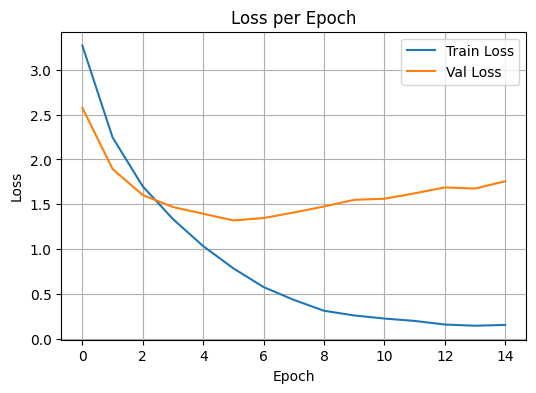

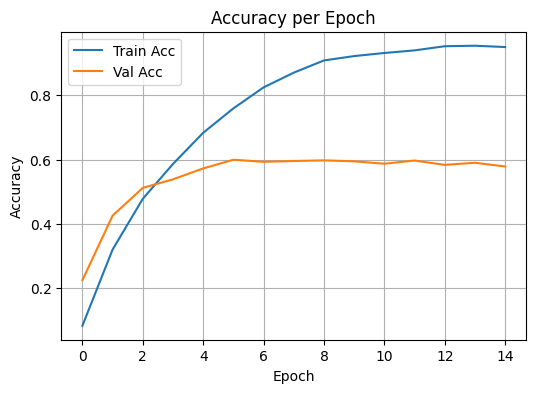

In [221]:
plot_loss_acc(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

In [222]:
test_model(test_loader, model)

Validation Acc: 0.6005


### ResNetClassifierNotTrained

In [225]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetClassifierNotTrained(num_classes=output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15

In [226]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=15)

Epoch 1/15 | Train Loss: 3.2841, Acc: 0.0512 | Val Loss: 3.2521, Acc: 0.0745
Epoch 2/15 | Train Loss: 2.3408, Acc: 0.2795 | Val Loss: 1.5372, Acc: 0.4985
Epoch 3/15 | Train Loss: 1.0761, Acc: 0.6501 | Val Loss: 1.0435, Acc: 0.6615
Epoch 4/15 | Train Loss: 0.6082, Acc: 0.8062 | Val Loss: 0.6835, Acc: 0.7955
Epoch 5/15 | Train Loss: 0.3949, Acc: 0.8707 | Val Loss: 0.4924, Acc: 0.8380
Epoch 6/15 | Train Loss: 0.2540, Acc: 0.9184 | Val Loss: 0.4463, Acc: 0.8545
Epoch 7/15 | Train Loss: 0.1648, Acc: 0.9477 | Val Loss: 0.4846, Acc: 0.8465
Epoch 8/15 | Train Loss: 0.1228, Acc: 0.9607 | Val Loss: 0.4848, Acc: 0.8550
Epoch 9/15 | Train Loss: 0.0825, Acc: 0.9755 | Val Loss: 0.4215, Acc: 0.8755
Epoch 10/15 | Train Loss: 0.0725, Acc: 0.9778 | Val Loss: 0.3819, Acc: 0.8865
Epoch 11/15 | Train Loss: 0.0648, Acc: 0.9801 | Val Loss: 0.3976, Acc: 0.8920
Epoch 12/15 | Train Loss: 0.0475, Acc: 0.9858 | Val Loss: 0.5242, Acc: 0.8720
Epoch 13/15 | Train Loss: 0.0535, Acc: 0.9829 | Val Loss: 0.6080, Acc: 0.

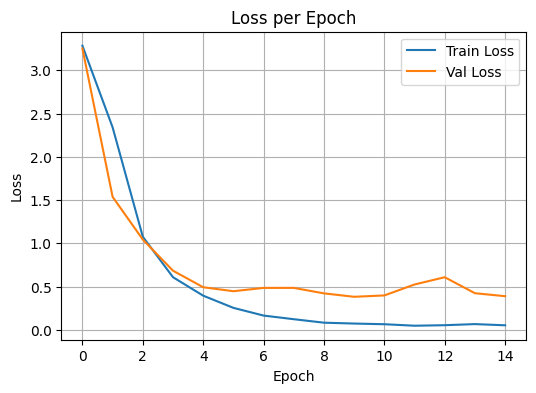

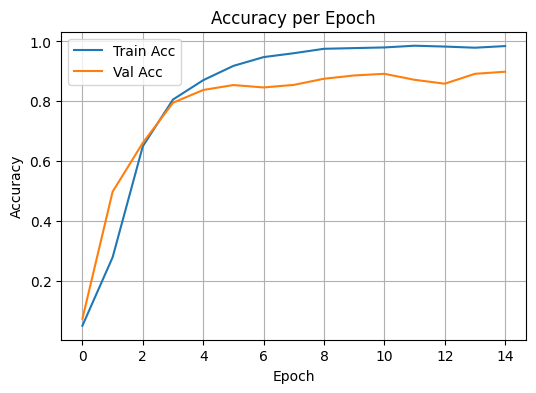

In [227]:
plot_loss_acc(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

In [228]:
test_model(test_loader, model)

Validation Acc: 0.8960


### ResNetClassifierPretrained

In [229]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetClassifierPretrained(num_classes=output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 13

In [230]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=15)

Epoch 1/15 | Train Loss: 1.0395, Acc: 0.6794 | Val Loss: 0.4753, Acc: 0.8415
Epoch 2/15 | Train Loss: 0.3614, Acc: 0.8834 | Val Loss: 0.3294, Acc: 0.8925
Epoch 3/15 | Train Loss: 0.2252, Acc: 0.9289 | Val Loss: 0.3081, Acc: 0.9075
Epoch 4/15 | Train Loss: 0.1559, Acc: 0.9516 | Val Loss: 0.3054, Acc: 0.9115
Epoch 5/15 | Train Loss: 0.1075, Acc: 0.9661 | Val Loss: 0.2763, Acc: 0.9145
Epoch 6/15 | Train Loss: 0.0926, Acc: 0.9693 | Val Loss: 0.2885, Acc: 0.9215
Epoch 7/15 | Train Loss: 0.0944, Acc: 0.9708 | Val Loss: 0.2522, Acc: 0.9315
Epoch 8/15 | Train Loss: 0.0659, Acc: 0.9780 | Val Loss: 0.2029, Acc: 0.9385
Epoch 9/15 | Train Loss: 0.0662, Acc: 0.9779 | Val Loss: 0.2128, Acc: 0.9375
Epoch 10/15 | Train Loss: 0.0616, Acc: 0.9798 | Val Loss: 0.2548, Acc: 0.9250
Epoch 11/15 | Train Loss: 0.0516, Acc: 0.9838 | Val Loss: 0.2703, Acc: 0.9270
Epoch 12/15 | Train Loss: 0.0573, Acc: 0.9811 | Val Loss: 0.2238, Acc: 0.9295
Epoch 13/15 | Train Loss: 0.0476, Acc: 0.9854 | Val Loss: 0.2801, Acc: 0.

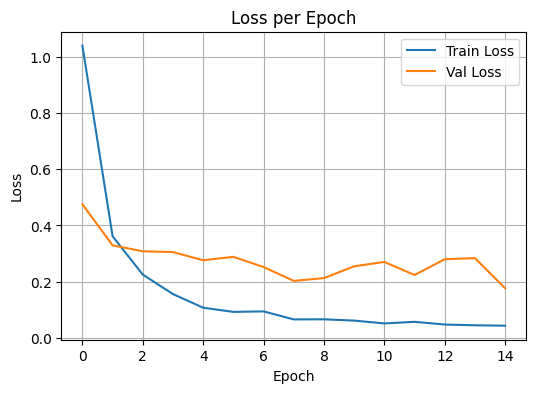

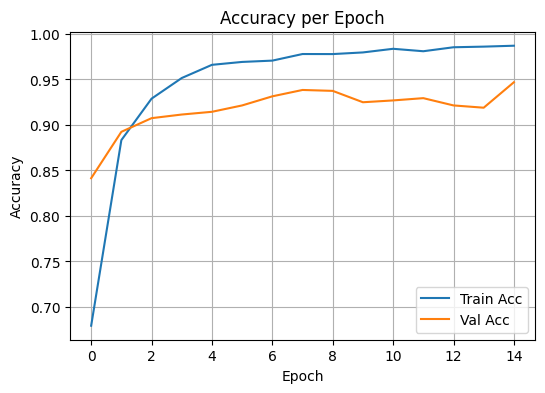

In [231]:
plot_loss_acc(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

In [232]:
test_model(test_loader, model)

Validation Acc: 0.9375


Лучшие результаты были получены на ResNetClassifierPretrained

# Сабмит результатов на лучшей модели ResNetClassifierPretrained

In [238]:
submission.head()

,Id,Category
0,0,13
1,1,20
2,2,12
3,3,7
4,4,8


In [240]:
X_test_tensor = transform_images(img_submission, transform)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
all_preds = []

with torch.no_grad():
    for images_tuple in test_loader:
        images = images_tuple[0].to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

submission['Category'] = all_preds

submission_path = '/content/drive/MyDrive/MFTI/SEM_02/Deep_learning/submission_olga_poletkina.csv'
submission.to_csv(submission_path, index=False)

print(f"Submission сохранен: {submission_path}")

Submission сохранен: /content/drive/MyDrive/MFTI/SEM_02/Deep_learning/submission_olga_poletkina.csv


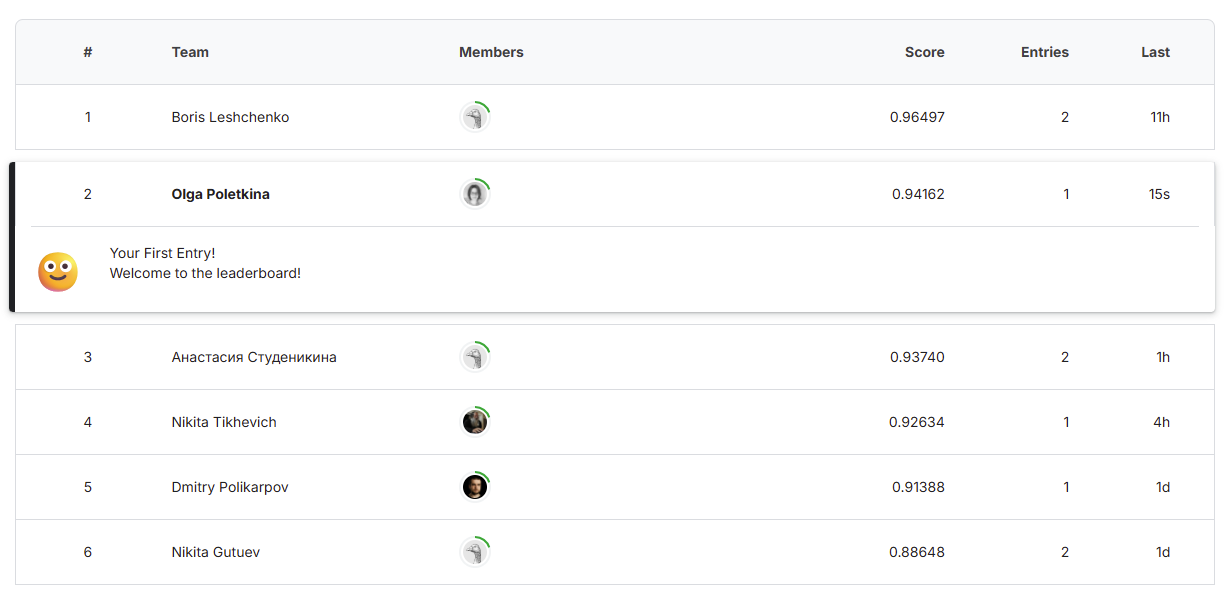